<h1>Load dependencies</h1>

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import math
import numpy as np
import pandas as pd

Using TensorFlow backend.


<h2>Inspect the data</h2>
The target value is a sequential time series, generated by the R-script "SimluateData.R".
<br>The values over the first 10,000x10minutes is plotted below. 

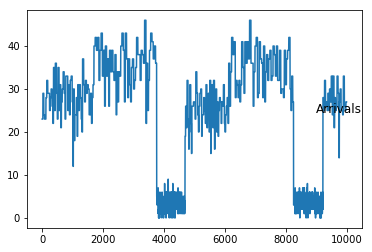

In [57]:
outputfile='SimulatedData.csv'

# load dataset
dataset = read_csv(outputfile, header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [1]
i = 1

# plot first 10.000 obs of target
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:10000, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

<h2>Data prep: Standardization & Transformation </h2>

In [2]:
# load dataset
dataset = read_csv('SimulatedData.csv', header=0, index_col=0)#dataset = dataset.drop('Weekday', 1)

#Dummify the weekday variable
just_dummies = pd.get_dummies(dataset['Weekday'])
dataset = pd.concat([dataset, just_dummies], axis=1)      
dataset.drop(['Weekday'], inplace=True, axis=1)

# ensure all data is float
values = dataset.values
values = values.astype('float32')

#Make placeholders;
minimas=[]
maximas=[]
varnames=[]
newdata = dataset

#RANGE TRANSFORMATION: normalize to 0-1 interval
for column in dataset:
    minima=np.min(dataset[column])
    maxima=np.max(dataset[column])
    X = dataset[column]
    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    newdata[column] = X_std * (1 - 0) + 0
    
    #store the values
    minimas.append(minima)
    maximas.append(maxima)
    varnames.append(column)
    #print(np.max(newdata[column]))
    
#Generate lookup table for later back-transformation
Transformations = pd.DataFrame(
    {'column': varnames,
     'mini': minimas,
     'maxi': maximas
    })
print(Transformations.head())
print(newdata.head())

          column       maxi      mini
0       Interval  60.000000  1.000000
1       Arrivals  53.000000  0.000000
2  Checkouttimes  18.335335  0.086408
3         Fredag   1.000000  0.000000
4         Lørdag   1.000000  0.000000
            Interval  Arrivals  Checkouttimes  Fredag  Lørdag  Mandag  Onsdag  \
Date                                                                            
2016-01-01       0.0  0.433962       0.104813     1.0     0.0     0.0     0.0   
2016-01-01       0.0  0.433962       0.184281     1.0     0.0     0.0     0.0   
2016-01-01       0.0  0.433962       0.070415     1.0     0.0     0.0     0.0   
2016-01-01       0.0  0.433962       0.274276     1.0     0.0     0.0     0.0   
2016-01-01       0.0  0.433962       0.198782     1.0     0.0     0.0     0.0   

            Tirsdag  Torsdag  
Date                          
2016-01-01      0.0      0.0  
2016-01-01      0.0      0.0  
2016-01-01      0.0      0.0  
2016-01-01      0.0      0.0  
2016-01-01      0.

<h2>Normalization & lagging </h2>
Inputs are normalized in order to avoid problems with the gradients. Lagged values are added in order to do time-series modelling.

In [3]:
# Generate function that converts series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# frame as supervised learning: Predict next hour (6X1 obs) using last hour (6X1 obs)
reframed = series_to_supervised(newdata.values, n_in=6, n_out=6, dropnan=True)
reframed = pd.DataFrame(reframed)
print(reframed[:2])
print(len(reframed))

# drop columns we don't want to predict => all t+variables which is not the target
#Target == var2

reframed.drop(["var1(t+5)","var3(t+5)","var4(t+5)","var5(t+5)","var6(t+5)","var7(t+5)","var8(t+5)","var9(t+5)",
              "var1(t+4)","var3(t+4)","var4(t+4)","var5(t+4)","var6(t+4)","var7(t+4)","var8(t+4)","var9(t+4)",
              "var1(t+3)","var3(t+3)","var4(t+3)","var5(t+3)","var6(t+3)","var7(t+3)","var8(t+3)","var9(t+3)",
              "var1(t+2)","var3(t+2)","var4(t+2)","var5(t+2)","var6(t+2)","var7(t+2)","var8(t+2)","var9(t+2)",
              "var1(t+1)","var3(t+1)","var4(t+1)","var5(t+1)","var6(t+1)","var7(t+1)","var8(t+1)","var9(t+1)",
              "var1(t)","var3(t)","var4(t)","var5(t)","var6(t)","var7(t)","var8(t)","var9(t)"], inplace=True, axis=1)

print(reframed[:2])
#print(reframed.head())

   var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
6        0.0   0.433962   0.104813        1.0        0.0        0.0   
7        0.0   0.433962   0.184281        1.0        0.0        0.0   

   var7(t-6)  var8(t-6)  var9(t-6)  var1(t-5)    ...      var9(t+4)  \
6        0.0        0.0        0.0        0.0    ...            0.0   
7        0.0        0.0        0.0        0.0    ...            0.0   

   var1(t+5)  var2(t+5)  var3(t+5)  var4(t+5)  var5(t+5)  var6(t+5)  \
6        0.0   0.433962   0.479576        1.0        0.0        0.0   
7        0.0   0.433962   0.358995        1.0        0.0        0.0   

   var7(t+5)  var8(t+5)  var9(t+5)  
6        0.0        0.0        0.0  
7        0.0        0.0        0.0  

[2 rows x 108 columns]
102570
   var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
6        0.0   0.433962   0.104813        1.0        0.0        0.0   
7        0.0   0.433962   0.184281        1.0        0.0        0.0   

  

<h2>Split and reshape the data</h2>
Train and test set is generated, and finally reshaped into 3-dimensional data.

In [4]:
# split into train and test sets
values = reframed.values
n_train_hours = int(np.floor(values.shape[0]/2)) #180*8*6 #half a year, 8 hours a day, 6x10 minutes per hour .... ish

train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

((51285, 1, 59), (51285,), (51285, 1, 59), (51285,))


<h2>Train the model:</h2>
The chosen LSTM architecture (1 layer) is fairly simple, since the simulated data is as well. This is in order to avoid overfitting. ADAM optimizer is used with standard params in order to minimize loss (mean absolute error).


Train on 51285 samples, validate on 51285 samples
Epoch 1/20
7s - loss: 0.2121 - val_loss: 0.0723
Epoch 2/20
8s - loss: 0.0640 - val_loss: 0.0555
Epoch 3/20
7s - loss: 0.0476 - val_loss: 0.0394
Epoch 4/20
6s - loss: 0.0351 - val_loss: 0.0321
Epoch 5/20
6s - loss: 0.0309 - val_loss: 0.0317
Epoch 6/20
6s - loss: 0.0306 - val_loss: 0.0316
Epoch 7/20
6s - loss: 0.0283 - val_loss: 0.0280
Epoch 8/20
6s - loss: 0.0271 - val_loss: 0.0302
Epoch 9/20
6s - loss: 0.0261 - val_loss: 0.0309
Epoch 10/20
6s - loss: 0.0248 - val_loss: 0.0287
Epoch 11/20
6s - loss: 0.0249 - val_loss: 0.0306
Epoch 12/20
6s - loss: 0.0248 - val_loss: 0.0321
Epoch 13/20
6s - loss: 0.0235 - val_loss: 0.0261
Epoch 14/20
6s - loss: 0.0246 - val_loss: 0.0245
Epoch 15/20
6s - loss: 0.0238 - val_loss: 0.0266
Epoch 16/20
6s - loss: 0.0231 - val_loss: 0.0242
Epoch 17/20
6s - loss: 0.0230 - val_loss: 0.0294
Epoch 18/20
6s - loss: 0.0238 - val_loss: 0.0424
Epoch 19/20
6s - loss: 0.0212 - val_loss: 0.0213
Epoch 20/20
6s - loss: 0.022

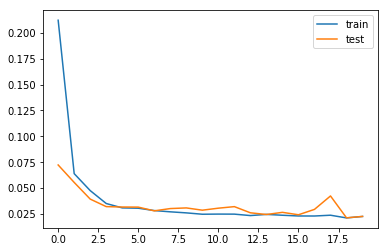

In [5]:
# design network
model = Sequential()
model.add(LSTM(1, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, 
                    epochs=20, 
                    batch_size=75, 
                    validation_data=(test_X, test_y), 
                    verbose=2, 
                    shuffle=False) #false

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

<h2>Prediction & evaluation:</h2>
In this section, a prediction of the next 2 hours are made. This will be a vector of length 6*2, since every observation is the amount of customers in 10-minute intervals. The evaluation metrics (MSE, RMSE, MAE) are also calculated for evaluation purposes.

In [58]:
# make a prediction on full test set
yhat = model.predict(inputvector)

# store the actual values
y = test_y

# Backtransformation for y and yhat
Ytrans = Transformations.loc[Transformations['column'] == "Arrivals"]

for index, row in Ytrans.iterrows():
    mini = row["mini"]
    maxi = row["maxi"]
    #back-transform:
    X = yhat
    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    yhat_new = X_std * (maxi - mini) + mini
    X = y
    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    y_new = X_std * (maxi - mini) + mini
    #Convert to integer, and shorten it to specified period
    yhat_new = np.floor(yhat_new) #
    y_new = np.floor(y_new) #
    
# store all the normalized residuals
resid=y_new-yhat_new.T

In [59]:
#Calculate evaluation metrics
print("Calculating eval_metrics on ",len(y_new)," observations")
MSE = np.mean((y_new-yhat_new)**2) #[0:1000]
print("MSE =",MSE)
RMSE = np.sqrt(MSE)
print("RMSE =",RMSE)
MAE = np.mean(np.abs(y_new-yhat_new)) #[0:1000]
print("MAE =",MAE)

('Calculating eval_metrics on ', 51285, ' observations')
('MSE =', 354.06090276234971)
('RMSE =', 18.816506125270699)
('MAE =', 14.751234532151283)


<h3>Residuals</h3><br>
Inspecting the residuals of the predictions. Seems like the residuals are not centered exactly around 0.

('mean resid =', -3.0421565759968803, 'min resid =', -41.0, 'max resid =', 27.0)


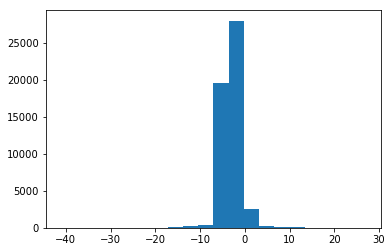

51285


In [60]:
#Inspect the residuals of the predictions:
print("mean resid =",np.mean(resid),"min resid =",np.min(resid),"max resid =",np.max(resid))
resid_s = resid.T#[0:5000]
pyplot.hist(resid_s,bins=20)
pyplot.show()
print(len(resid_s))

<h3>Using a subset as test-period</h3>
Below a period of 120 minutes is selected for the forecast, in order to proceed with the staffing plan.
<br>Actual vs. predicted amount of customers for the 120 minutes is illustrated by the line plot.

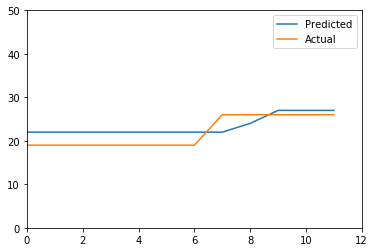

[ 19.  19.  19.  19.  19.  19.  19.  26.  26.  26.  26.  26.]
[[ 22.  22.  22.  22.  22.  22.  22.  22.  24.  27.  27.  27.]]


In [61]:
#Test-use with data for next 2 hours (6X2 obs) using last 6 hours (6X6 obs), defined by the model.
periods = 2*6 
startoff = 6*8*5 #5 days into the sample

#Subset on the decided period:
yhat_new = yhat_new[startoff:startoff+periods]
y_new = y_new[startoff:startoff+periods]

#Plot the first predicted values
pyplot.plot(yhat_new, label="Predicted")
pyplot.plot(y_new, label="Actual")
v = [0, 12, 0, 50] #[xmin, xmax, ymin, ymax]
pyplot.axis(v)
pyplot.legend()
pyplot.show()

#Print the selected sequence
print(y_new)
print(yhat_new.T)

<h1>Generate staffing plan </h1>
When the sequence of expected customers is generated, an optimal plan that minizes staffing costs, whilst fulfulling the expected demand for the next two hours, can be calculated. This operation is definded as a function (make_workplan), so that a plan can be iterated over as long an interval as is needed. 

<b>Model:</b><br>
<u>Objective:</u> MIN Z = ServiceDesks x cost<br>
<u>St.</u> ServiceDesks x capacity >= Expected demand<br><br>
Where: <br>
- ServiceDesks is binary (0 if closed, 1 if open)
- Cost is hourly wage for 1 worker divided by 6
- Capacity is the amount of customers that can be processed in 10 minutes

In [66]:
#Load the package
from pulp import *
#Store the results:
import pandas as pd

def make_workplan(Expected_customers,stations=15):

    #Load the predicted amount of customers
    LSTM_Prediction = Expected_customers
    
    #Make problem:
    prob = LpProblem("IKEA_CHECKOUT",LpMinimize)
    
    #Setup decision variables
    SD1=LpVariable('ServiceDesk1', cat='Binary')
    SD2=LpVariable('ServiceDesk2', cat='Binary')
    SD3=LpVariable('ServiceDesk3', cat='Binary')
    SD4=LpVariable('ServiceDesk4', cat='Binary')
    SD5=LpVariable('ServiceDesk5', cat='Binary')
    SD6=LpVariable('ServiceDesk6', cat='Binary')
    SD7=LpVariable('ServiceDesk7', cat='Binary')
    SD8=LpVariable('ServiceDesk8', cat='Binary')
    SD9=LpVariable('ServiceDesk9', cat='Binary')
    SD910=LpVariable('ServiceDesk910', cat='Binary')
    SD911=LpVariable('ServiceDesk911', cat='Binary')
    SD912=LpVariable('ServiceDesk912', cat='Binary') 
    SD913=LpVariable('ServiceDesk913', cat='Binary') 
    SD914=LpVariable('ServiceDesk914', cat='Binary') 
    SD915=LpVariable('ServiceDesk915', cat='Binary') #Special desk
    
    # The objective function: Minimize costs
    prob +=   20*SD1 + 20*SD2 + 20*SD3 + 20*SD4 + 20*SD5 + 20*SD6 + 20*SD7 + 20*SD8 + 20*SD9 + 20*SD910 + 20*SD911 + 20*SD912 + 20*SD913 + 20*SD914 + 20*SD915, "Cost per 10 minutes"

    #Subject to; Capacity of each cash-out service desk
    prob += 12*SD1 + 12*SD2 + 10*SD3 + 10*SD4 + 10*SD5 + 10*SD6 + 10*SD7 + 10*SD8 + 10*SD9 + 10*SD910 + 10*SD911 + 10*SD912 + 10*SD913 + 10*SD914 + 10*SD915 >= LSTM_Prediction, "Forecasted_Customers"
    
    # The problem data is written to an .lp file
    prob.writeLP("IKEA_CASHOUT.lp")
    
    #Solve
    prob.solve()
    
    # The status of the solution is printed to the screen
    print("Status:", LpStatus[prob.status])
    
    # The optimised objective function value is printed to the screen
    print("Total labor Cost the next 10 minutes = ", value(prob.objective))
    listvar = []
    listval = []
    listcost = []
    listcustom = []

    for v in prob.variables():
        listvar.append(v.name)
        listval.append(v.varValue)
        listcost.append(value(prob.objective))
        listcustom.append(LSTM_Prediction)
        
        #print(v.name, "=", v.varValue)
    
    #Store a DF
    StaffingPlan = pd.DataFrame(
    {'ServiceDesk': listvar,
     'Open': listval,
     'Total_Labor_Cost_10min': listcost,
     'Total_Forecasted_Cust_10min' : listcustom
    })
    
    StaffingPlan.head()
    return(StaffingPlan)

<h2>Expected amount of customers</h2>

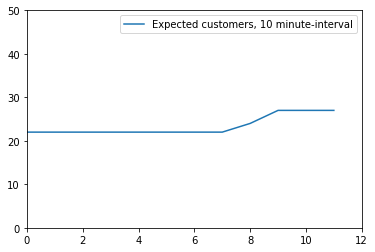

In [67]:
#Plot the sequence in real values
pyplot.plot(yhat_new, label="Expected customers, 10 minute-interval")
v = [0, 12, 0, 50] #[xmin, xmax, ymin, ymax]
pyplot.axis(v)
pyplot.legend()
pyplot.show()

<h3>Loop the through the forecast</h3>
Below the 'make_workplan' is iterated for every prediction such that a staffing plan in 10-minute intervals is created.

In [88]:
count = [1]
counters = []
for x in count:
    for i in range(len(Test_res)):
        counters.append(x)
        
print(counters)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [102]:
#set up the list of forecasted values;
LSTM_Forecast = np.floor(yhat_new)
Results = []
count = [0]

for i in LSTM_Forecast:
    Test_res = make_workplan(i)
    counters = []
    count[0] += +1
    for x in count:
        for j in range(len(Test_res)):
            counters.append(x)
    counters = pd.DataFrame({"IntervalNo": counters})
    Test_res = pd.concat([counters,Test_res], axis=1)

    print(i)
    
    Results.append(Test_res)
    
# Convert the list into a df;
appended_data = pd.concat(Results, axis=0)

('Status:', 'Optimal')
('Total labor Cost the next 10 minutes = ', 40.0)
[ 22.]
('Status:', 'Optimal')
('Total labor Cost the next 10 minutes = ', 40.0)
[ 22.]
('Status:', 'Optimal')
('Total labor Cost the next 10 minutes = ', 40.0)
[ 22.]
('Status:', 'Optimal')
('Total labor Cost the next 10 minutes = ', 40.0)
[ 22.]
('Status:', 'Optimal')
('Total labor Cost the next 10 minutes = ', 40.0)
[ 22.]
('Status:', 'Optimal')
('Total labor Cost the next 10 minutes = ', 40.0)
[ 22.]
('Status:', 'Optimal')
('Total labor Cost the next 10 minutes = ', 40.0)
[ 22.]
('Status:', 'Optimal')
('Total labor Cost the next 10 minutes = ', 40.0)
[ 22.]
('Status:', 'Optimal')
('Total labor Cost the next 10 minutes = ', 40.0)
[ 24.]
('Status:', 'Optimal')
('Total labor Cost the next 10 minutes = ', 60.0)
[ 27.]
('Status:', 'Optimal')
('Total labor Cost the next 10 minutes = ', 60.0)
[ 27.]
('Status:', 'Optimal')
('Total labor Cost the next 10 minutes = ', 60.0)
[ 27.]


<h3>Example staffing plan</h3>
Below is an example staffing plan, showing the last 20 minutes of the predicted 2 hours.

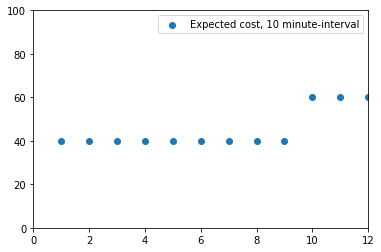

,IntervalNo,Open,ServiceDesk,Total_Forecasted_Cust_10min,Total_Labor_Cost_10min
0,1,1.0,ServiceDesk1,[22.0],40.0
1,1,1.0,ServiceDesk2,[22.0],40.0
2,1,0.0,ServiceDesk3,[22.0],40.0
3,1,0.0,ServiceDesk4,[22.0],40.0
4,1,0.0,ServiceDesk5,[22.0],40.0
5,1,0.0,ServiceDesk6,[22.0],40.0
6,1,0.0,ServiceDesk7,[22.0],40.0
7,1,0.0,ServiceDesk8,[22.0],40.0
8,1,0.0,ServiceDesk9,[22.0],40.0
9,1,0.0,ServiceDesk910,[22.0],40.0


In [122]:
#store the results
appended_data.to_csv(path_or_buf="StaffingPlan.csv", sep=',')

#Plot the costs:
sub = appended_data.drop_duplicates(subset="IntervalNo", keep='first', inplace=False)
pyplot.scatter(sub["IntervalNo"], sub["Total_Labor_Cost_10min"], label="Expected cost, 10 minute-interval")
v = [0, 12, 0, 100] #[xmin, xmax, ymin, ymax]
pyplot.axis(v)
pyplot.legend()
pyplot.show()

#Inspect the results:
appended_data.head(30)